In [1]:
from UTILITY_quickstart import *
import yaml

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
importedDefaultSettings

{'QA10361kG': -2.2481515833,
 'QA10371kG': 2.338890812,
 'QE10425kG': -1.0721888188,
 'QE10441kG': 1.3152401751,
 'QE10511kG': 0.2241208022,
 'QE10525kG': 0.6276060908,
 'B1EkG': 7.533,
 'B2EkG': -10.942,
 'B3EkG': 3.409,
 'Q1EkG': 161.4360968404,
 'Q2EkG': -154.5590355287,
 'Q3EkG': 108.7941468594,
 'Q4EkG': 131.423088959,
 'Q5EkG': -23.4326045613,
 'Q6EkG': -142.5421046346,
 'S1ELkG': 805.9672801375,
 'S2ELkG': -2136.4167033184,
 'S3ELkG': -1015.875800016,
 'S3ERkG': -1015.6966681687,
 'S2ERkG': -1997.9370300422,
 'S1ERkG': 810.3489936048,
 'Q5FFkG': -71.8850306368,
 'Q4FFkG': -82.0033811735,
 'Q3FFkG': 98.3510616716,
 'Q2FFkG': 127.9133844867,
 'Q1FFkG': -232.458400641,
 'Q0FFkG': 126.6477917559,
 'Q0DkG': -109.694,
 'Q1DkG': 180.862,
 'Q2DkG': -109.694,
 'S1EL_xOffset': 1.43612e-05,
 'S1EL_yOffset': 6.0683e-06,
 'S2EL_xOffset': 3.2023e-06,
 'S2EL_yOffset': -1.05401e-05,
 'S2ER_xOffset': 2.0237e-05,
 'S2ER_yOffset': 9.2307e-06,
 'S1ER_xOffset': 6.2816e-06,
 'S1ER_yOffset': 6.0259e-0

In [3]:
csrTF = False

inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]

tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e5,
)

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 100000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting


In [4]:
trackBeam(tao, centerBC14 = True, centerBC20 = True, verbose = True)

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Tracking!
trackBeam() exiting


In [5]:
savedData = {}

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)


for PActiveStr in ["PDrive", "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    #savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    #savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    #savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
    savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)

    savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
    savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
    
    savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

savedData["transverseCentroidOffset"] = np.sqrt(
        (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
        (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
    )


#savedData["lostChargeFraction"] = 1 - (tao.bunch_params("DTOTR")['n_particle_live'] / tao.bunch_params("BEGBC20")['n_particle_live'])
savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

In [6]:
savedData

{'PDrive_mean_x': -6.374495675793965e-07,
 'PDrive_mean_y': -1.7070360123745378e-06,
 'PDrive_sigma_x': 3.2836894880855767e-05,
 'PDrive_sigma_y': 1.5833105062376454e-05,
 'PDrive_mean_xp': 0.00012428523895263399,
 'PDrive_mean_yp': 9.262474715063883e-06,
 'PDrive_median_x': -3.11670948965851e-06,
 'PDrive_median_y': -1.5539709521849352e-06,
 'PDrive_median_xp': 0.00015771774885403044,
 'PDrive_median_yp': 9.547408039761161e-06,
 'PDrive_sigmaSI90_x': 2.768682486946009e-05,
 'PDrive_sigmaSI90_y': 1.0888281327751779e-05,
 'PDrive_emitSI90_x': 6.187291371248215e-05,
 'PDrive_emitSI90_y': 3.5427965502101927e-06,
 'PDrive_zLen': 1.950890033194113e-05,
 'PDrive_zCentroid': 991.3317493980087,
 'PWitness_mean_x': 1.3526035646285578e-05,
 'PWitness_mean_y': -3.196734737111446e-07,
 'PWitness_sigma_x': 2.1528006344198527e-05,
 'PWitness_sigma_y': 3.209747449175808e-05,
 'PWitness_mean_xp': -5.339543040571638e-05,
 'PWitness_mean_yp': 8.877935648469296e-06,
 'PWitness_median_x': 1.44600764884780

In [7]:
print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g}, {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g}, {1e6 * savedData["PDrive_zLen"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g}, {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g}, {1e6 * savedData["PWitness_zLen"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g}, {1e6 * PWitness["sigma_y"] :.3g}, {1e6 * PWitness["sigma_z"] :.3g} um""")

Bunch spacing: 		152 um
Transverse offset: 	17.6 um
Angular misalignment: 	0.207 mrad

Emittances and sigmas - implied by 90% charge
Driver emittance: 	61.9 × 3.54 um-rad
Witness emittance: 	11.3 × 8 um-rad
Driver sigma_x,y,z: 	27.7, 10.9, 19.5 um
Witness sigma_x,y,z: 	21.4, 30.7, 20.5 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	79 × 7.91 um-rad
Witness emittance: 	11.2 × 9.07 um-rad
Driver sigma_x,y,z: 	32.8, 15.8, 28.5 um
Witness sigma_x,y,z: 	21.5, 32.1, 20.9 um


Drive:


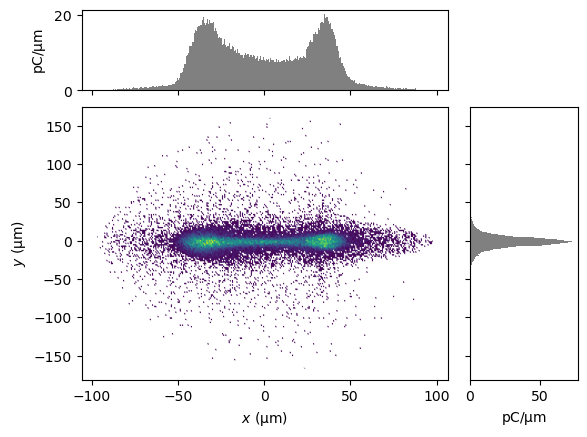

Witness:


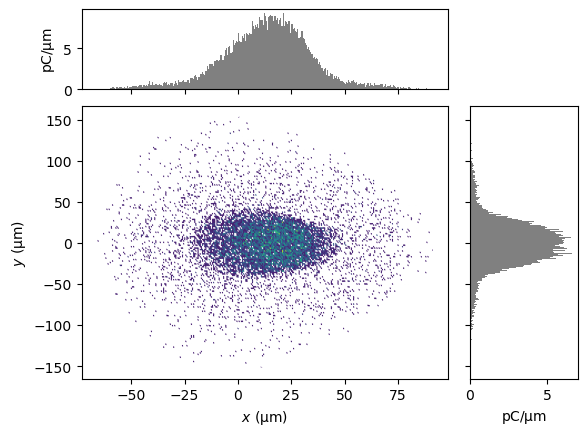

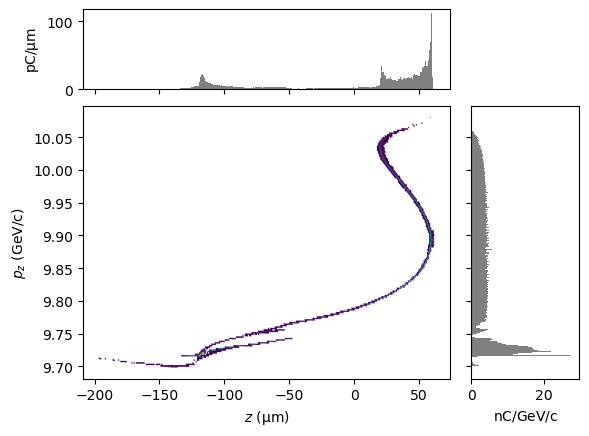

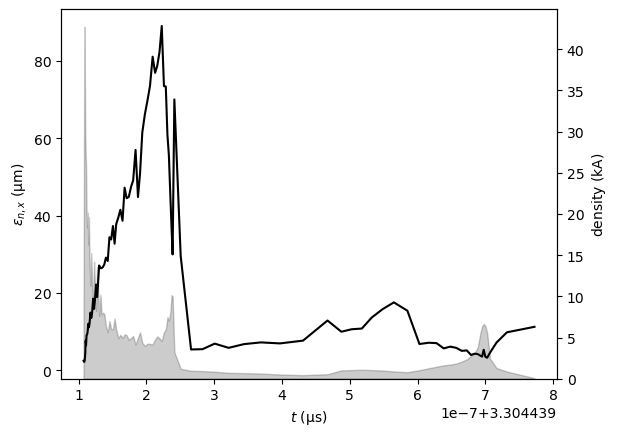

<Figure size 640x480 with 0 Axes>

In [8]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
print("Witness:")
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
#display(slicePlotMod(P, 'norm_emit_x', slice_key = "z", n_slice=100))
display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
plt.clf()

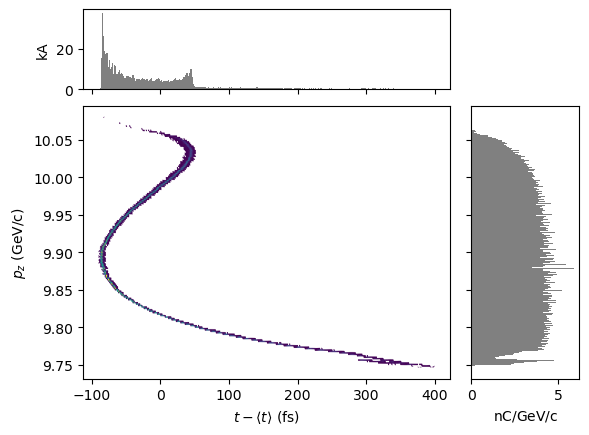

In [9]:
display(plotMod(PDrive, 'delta_t', 'pz', bins=300))

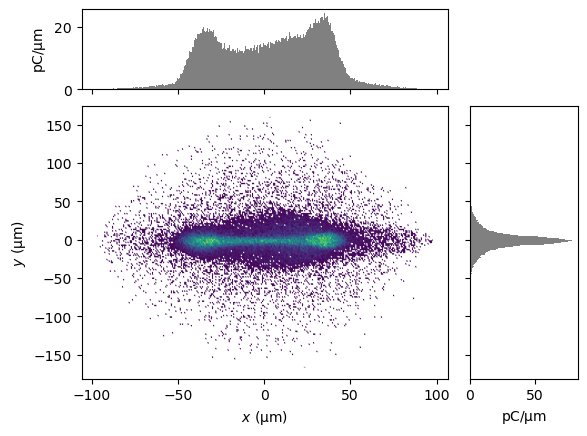

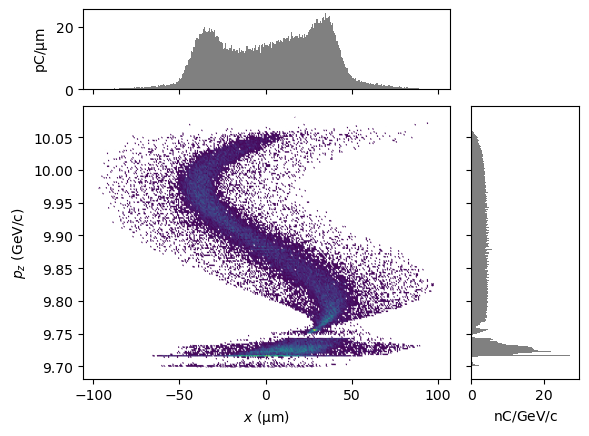

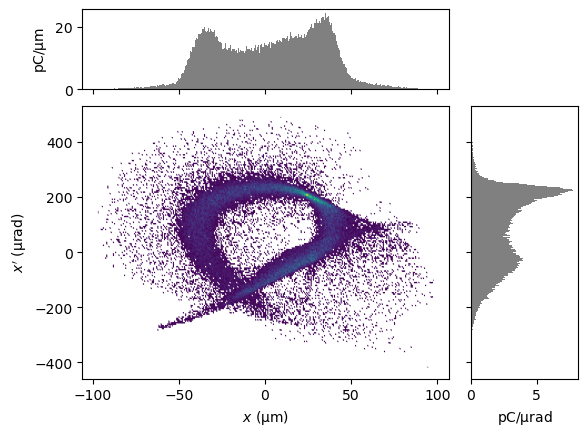

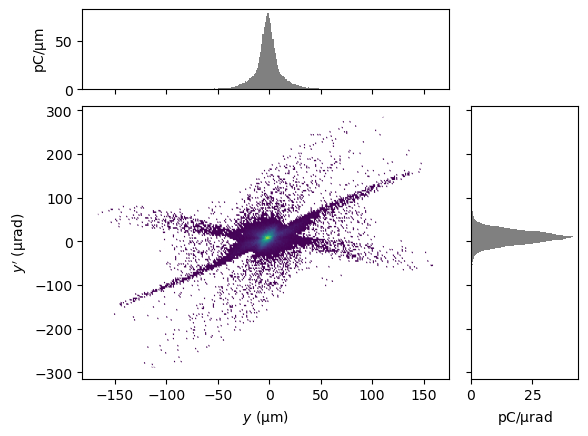

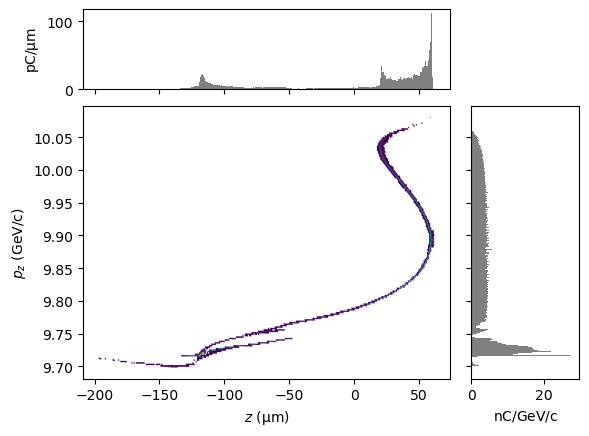

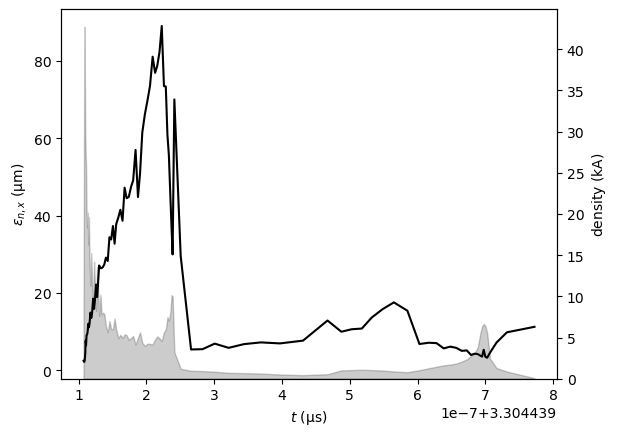

In [10]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))

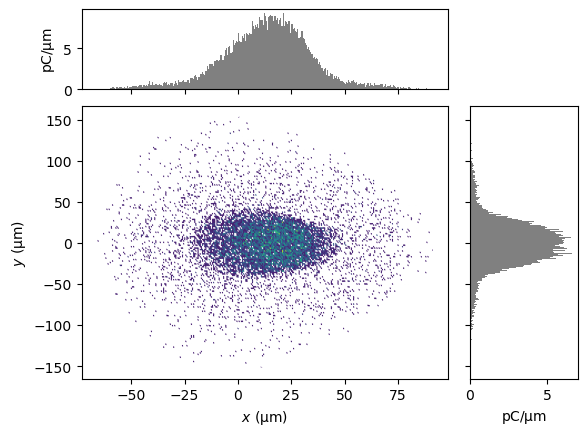

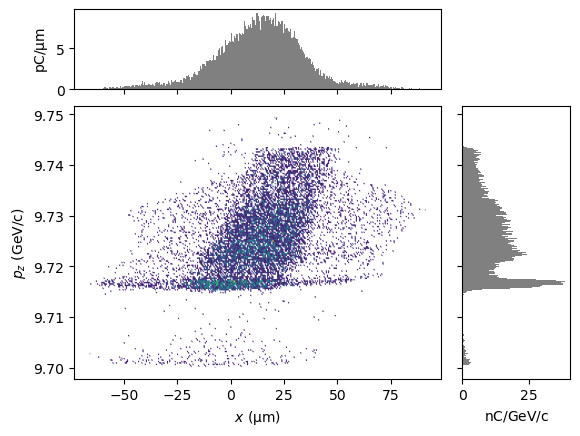

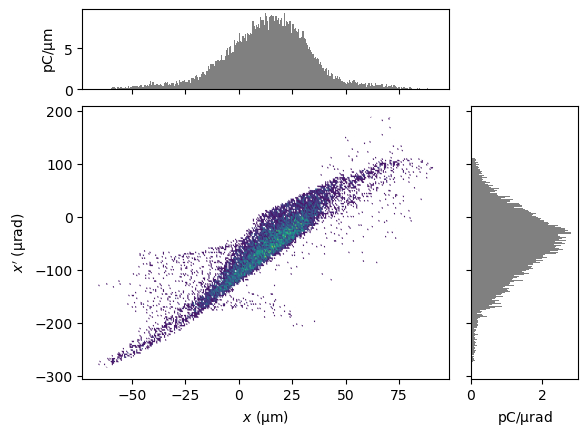

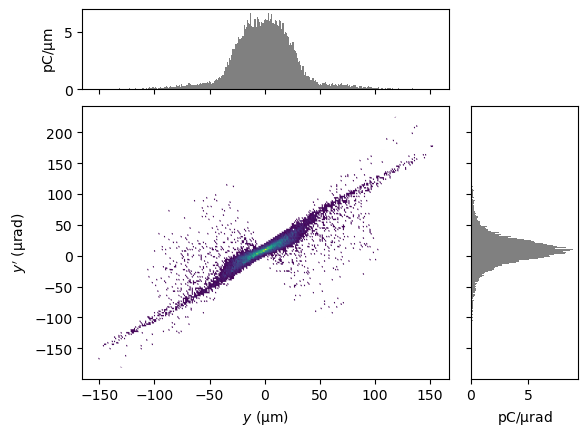

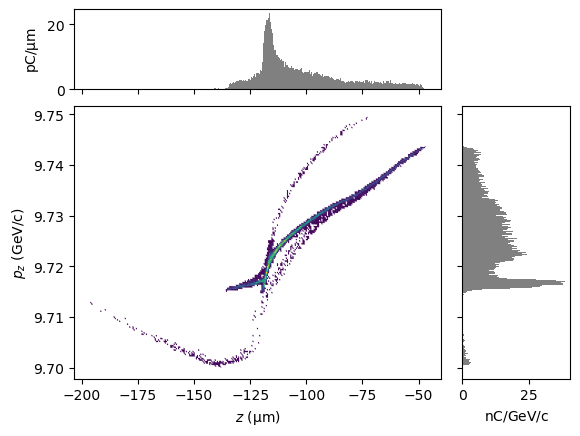

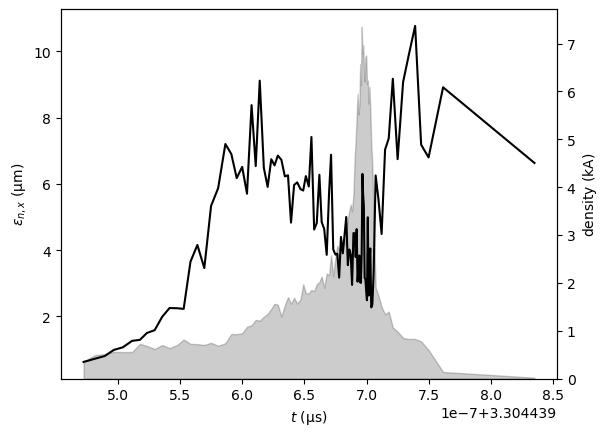

In [11]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'z', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


## Further study at other elements

In [12]:
?calcBMAG

Signature: calcBMAG(b0, a0, b, a)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [13]:
#def addBMAGToDict(dict, targetBeta, targetAlpha)

In [14]:
P = getBeamAtElement(tao, "PR10571")
PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.025256733245306, 1.0035304218965815
Drive BMAG:   1.3307432743976182, 1.2492637930209176
Witness BMAG: 2.3616368480811083, 3.058146118622585

System emit:  2.870726519472618e-06, 3.0659241967613478e-06
Drive emit:   2.0287768143012307e-06, 2.034139657037683e-06
Witness emit: 1.7605088294947592e-06, 1.7745050630865055e-06


In [15]:
P = getBeamAtElement(tao, "BEGBC20")
PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 4.025930041181191, 17.05791450382531
Drive alpha x / y: 0.3266380720330418, 1.070156980861122

System BMAG:  1.0410690573773307, 1.6225163715553648
Drive BMAG:   1.612787557266122, 1.1947568189236395
Witness BMAG: 3.1749298390400407, 5.3475550999762405

System emit:  7.359186430491196e-06, 2.7498956760543026e-06
Drive emit:   3.399327133932104e-06, 1.9080682859455925e-06
Witness emit: 4.002005060918192e-06, 2.985156465806334e-06


In [16]:
P = getBeamAtElement(tao, "MFFF")
PDrive, PWitness = getDriverAndWitness(P)


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 30.515104425844545, 17.940502717198417
Drive alpha x / y: -4.316277798022135, -0.932628684008119

System BMAG:  3.2625342199565543, 1.3038702933249495
Drive BMAG:   2.822756453502465, 1.0882181255548915
Witness BMAG: 1.9144319438729127, 3.6659743431488803

System emit:  3.2112160192173464e-05, 2.5142484591348003e-06
Drive emit:   2.257028362965343e-05, 1.7712688358491537e-06
Witness emit: 4.837452171971713e-06, 2.817823361683489e-06


In [17]:
P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 0.17305445131542732, 0.8460260315926107
System alpha x / y: -0.27302175452537936, -0.5030600456728779
Drive beta x / y: 0.1805934337904249, 0.5423318567187191
Drive alpha x / y: 0.4987381259242966, -0.15780458038577977
Witness beta x / y: 1.080981255932127, 3.1265608310159045
Witness alpha x / y: -2.5742860665349405, -2.9848340512978404
System BMAG:  1.725370601342601, 1.2163070166804881
Drive BMAG:   1.909255008080575, 1.014783489834888
Witness BMAG: 2.8448760298935962, 3.9189038277909987

System emit:  4.772011104549223e-05, 2.893844737974886e-06
Drive emit:   3.0211300271671357e-05, 1.987218972206865e-06
Witness emit: 4.512681461048891e-06, 2.8674504174251962e-06


PR10571


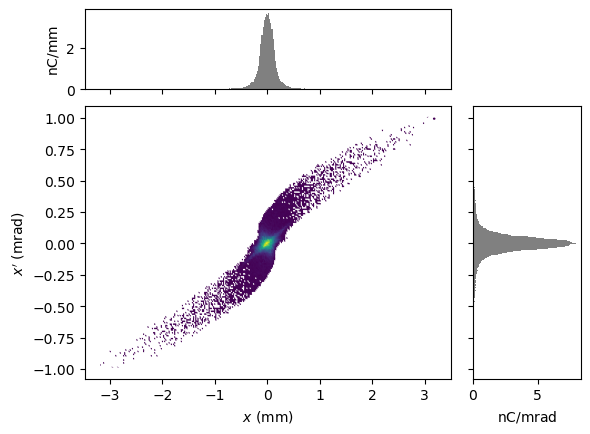

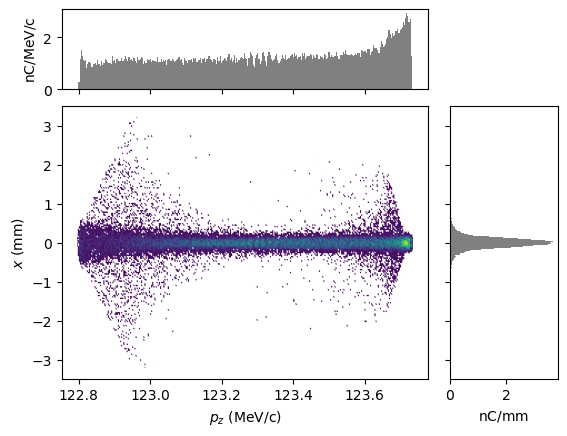

BEGBC20


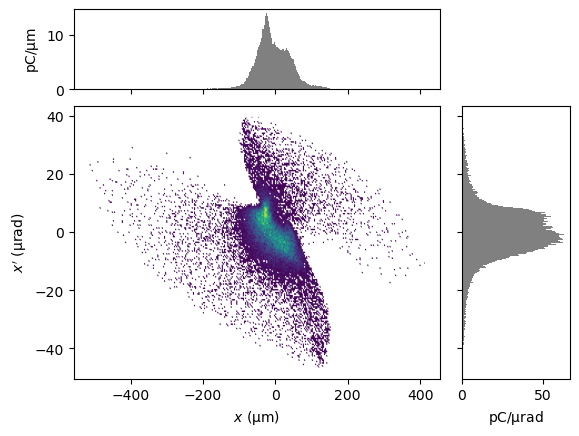

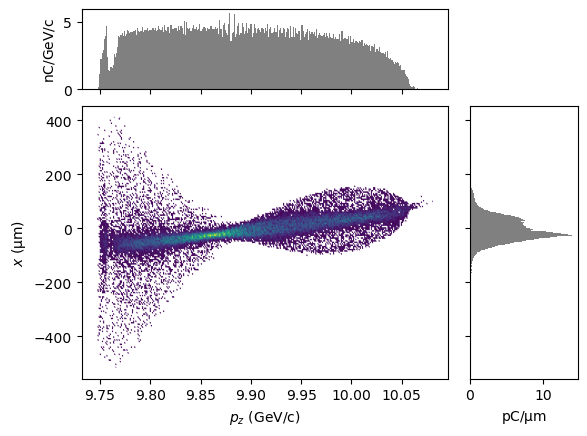

MFFF


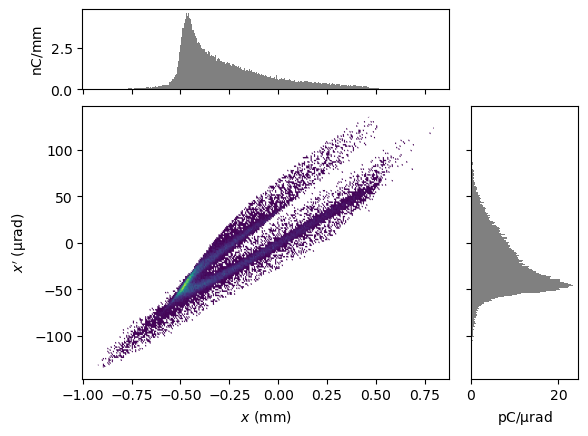

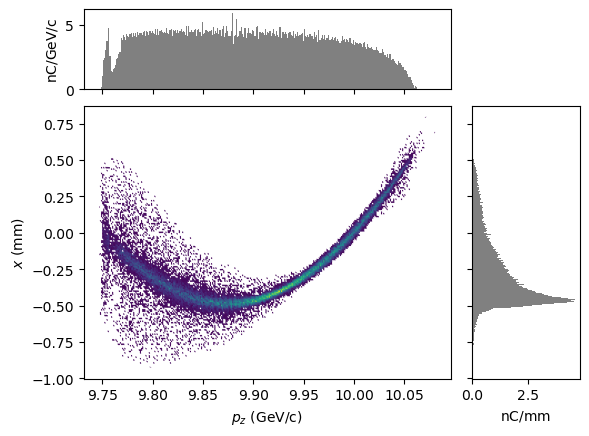

PENT


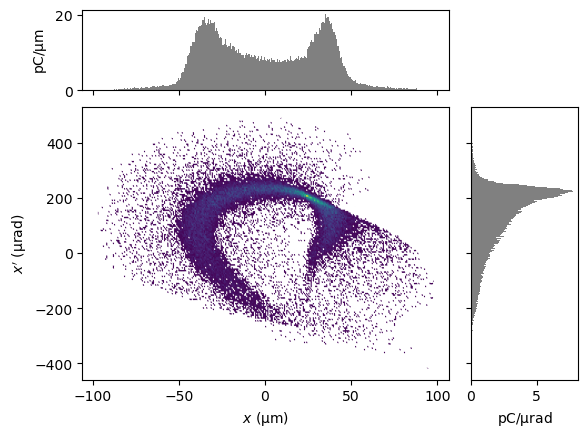

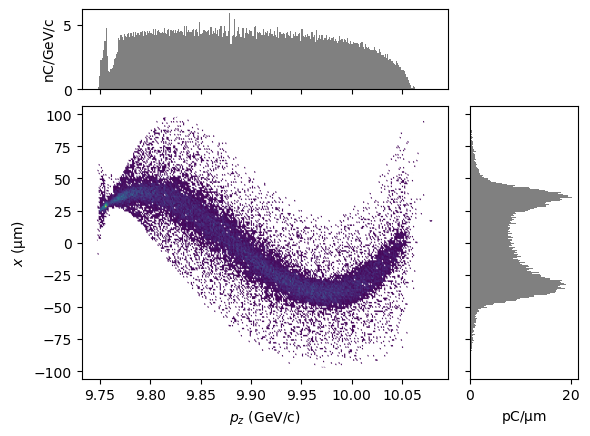

In [18]:

for activeElement in ["PR10571", "BEGBC20", "MFFF", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    PDrive, PWitness = getDriverAndWitness(P)
    
    display(plotMod(PDrive, 'x', 'xp',  bins=300))
    display(plotMod(PDrive, 'pz', 'x',  bins=300))

# Comparing golden lattice to present lattice

In [19]:
# tao = initializeTao(loadDefaultLatticeTF=True)
# tao.cmd("show ele PENT")

In [20]:
# tao = initializeTao(loadDefaultLatticeTF=False)
# tao.cmd("show ele PENT")

In [22]:
# tao = initializeTao(loadDefaultLatticeTF=True)
# getMatrix(tao, "BEGBC20", "PENT", print = True);

# print()

# tao = initializeTao(loadDefaultLatticeTF=False)
# getMatrix(tao, "BEGBC20", "PENT", print = True);